# Relax Inc. Data Science Challenge

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

In [23]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
# create user engagement dataframe
engagement_df = pd.read_csv('takehome_user_engagement.csv', 
                            parse_dates=['time_stamp'], 
                            infer_datetime_format=True)
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [25]:
def identify_adopted(df, group_col='user_id', time_col='time_stamp', count_col='visited', min_count=3):
    week_count = df.groupby([group_col, df[time_col].dt.strftime('%W')])[count_col].sum()
    adopted_df= week_count.where(week_count >= min_count).dropna().unstack().fillna(0).reset_index()
    adopted = adopted_df[group_col].tolist()
    return adopted

In [26]:
# create list of adopted users
adopted = identify_adopted(engagement_df)

In [27]:
# compute a Series of the total number of visits from each user
visit_count = engagement_df.groupby('user_id')['visited'].count().to_frame()

In [28]:
# load user info into dataframe
users_df = pd.read_csv('takehome_users.csv', 
                       index_col=0, encoding='Latin-1', 
                       parse_dates=['creation_time','last_session_creation_time']
                      )

In [29]:
# add visit count Series to users_df
users_df = users_df.merge(visit_count, left_index=True, right_index=True)

In [30]:
# add adopted_user column
users_df['adopted_user'] = users_df.index.isin(adopted).astype(int)
users_df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visited,adopted_user
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0,1,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0,14,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0,1,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0,1,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0,1,0


In [31]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 11 columns):
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null object
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
visited                       8823 non-null int64
adopted_user                  8823 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 827.2+ KB


In [32]:
# convert last_session to datetime
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'].astype(int), unit='s')

# convert creation source to categorical
users_df.creation_source = users_df.creation_source.astype('category')

In [33]:
# compute login stats for each unadopted users
unadopted_min = users_df[users_df.adopted_user == False]['visited'].min()
unadopted_max = users_df[users_df.adopted_user == False]['visited'].max()
unadopted_mean = users_df[users_df.adopted_user == False]['visited'].mean()
unadopted_median = users_df[users_df.adopted_user == False]['visited'].median()

print('Unadopted User Stats')
print('Min Logins: {0}\nMax Logins: {1}\nMean Logins: {2:.0f}\nMedian Logins: {3:.0f}'.format(unadopted_min, 
                                                                    unadopted_max,
                                                                    unadopted_mean,
                                                                    unadopted_median))

print()
# compute login stats for each adopted users
adopted_min = users_df[users_df.adopted_user == True]['visited'].min()
adopted_max = users_df[users_df.adopted_user == True]['visited'].max()
adopted_mean = users_df[users_df.adopted_user == True]['visited'].mean()
adopted_median = users_df[users_df.adopted_user == True]['visited'].median()

print('Adopted User Stats')
print('Min Logins: {0}\nMax Logins: {1}\nMean Logins: {2:.0f}\nMedian Logins: {3:.0f}'.format(adopted_min, 
                                                                                     adopted_max, 
                                                                                     adopted_mean,
                                                                                     adopted_median))

Unadopted User Stats
Min Logins: 1
Max Logins: 34
Mean Logins: 2
Median Logins: 1

Adopted User Stats
Min Logins: 3
Max Logins: 606
Mean Logins: 136
Median Logins: 83


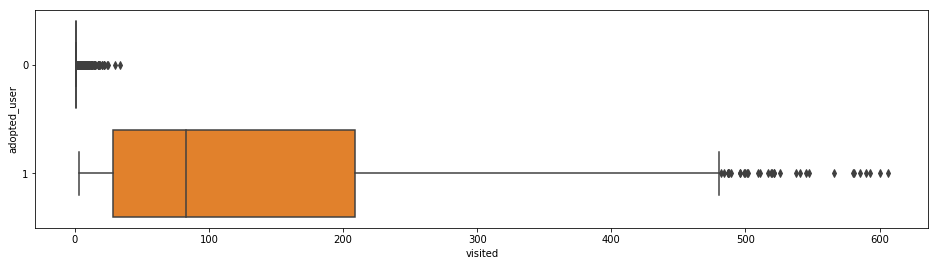

In [34]:
# plot the distribution of visits between adopted and non-adopted users
plt.figure(figsize=(16,4))
sns.boxplot(x='visited', y='adopted_user', data=users_df, orient='h')

creation_source
GUEST_INVITE          0.205290
ORG_INVITE            0.154015
PERSONAL_PROJECTS     0.191099
SIGNUP                0.144889
SIGNUP_GOOGLE_AUTH    0.148736
Name: adopted_user, dtype: float64


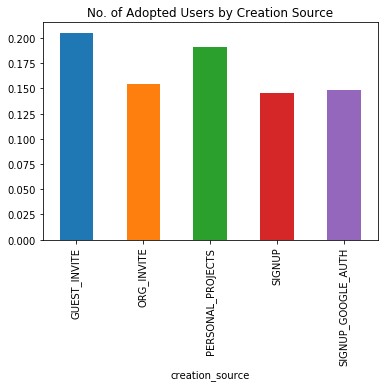

In [35]:
# Identify which factors predict future user adoption
print(users_df.groupby('creation_source')['adopted_user'].sum() / users_df.groupby('creation_source')['adopted_user'].count())

(users_df.groupby('creation_source')['adopted_user'].sum() / users_df.groupby('creation_source')['adopted_user'].count()).plot(kind='bar', 
                                                               title='No. of Adopted Users by Creation Source')

opted_in_to_mailing_list  adopted_user
0                         0               5531
                          1               1066
1                         0               1848
                          1                378
Name: adopted_user, dtype: int64


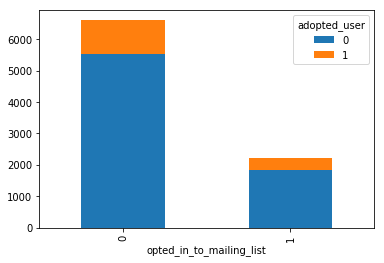

In [36]:
mail_list = users_df.groupby(['opted_in_to_mailing_list','adopted_user'])['adopted_user'].count()
print(mail_list)
mail_list.unstack().plot(kind='bar', stacked=True)

In [37]:
# compute the percent of adopted users based on mailing list status
mail_list_unstack = mail_list.unstack()
mail_list_unstack['pct'] = mail_list_unstack.iloc[1] / mail_list_unstack.sum(axis=1)
mail_list_unstack

adopted_user,0,1,pct
opted_in_to_mailing_list,,,
0,5531,1066,0.280127
1,1848,378,0.169811


In [38]:
# compute number of unique organizations
len(users_df.org_id.unique())

417

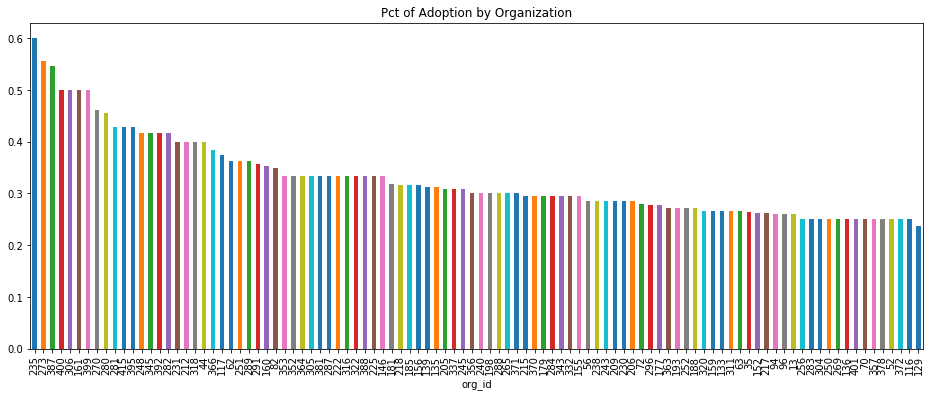

In [39]:
# compute the percent of adopted users by organization
org_adoption_pct = (users_df.groupby('org_id')['adopted_user'].sum() / users_df.groupby('org_id')['adopted_user'].count()).sort_values(ascending=False)

# the the 100 orgs with the highest adoption rate
org_adoption_pct[:100].plot(kind='bar', title='Pct of Adoption by Organization',figsize=(16,6))

In [40]:
# Prediction
# convert creation source categories to numerical codes
users_df['creation_source'] = pd.Categorical(users_df.creation_source).codes

In [41]:
# define features for gradient boosting model
features = users_df[['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id','visited']].copy()

# convert missing data
features.invited_by_user_id.fillna(-1, inplace=True)

In [42]:
# plot feature importances using gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances

X = features
y = users_df.adopted_user

# Create a new matplotlib figure
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(random_state=42), ax=ax)
viz.fit(X, y)
viz.poof()

ModuleNotFoundError: No module named 'yellowbrick'

In [43]:
# see how well the baseline GB model performs
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)
clf.score(X_test, y_test)

0.978021978021978

# Conclusion

Based on the data provided, we can conclude that the most important factor in predicting whether a user will adopt the platform is the number of visits. The gradient boosting algorithm seems to gain all of its information from the number of visits while creating a model with 97.8% accuracy. While a users number of visits gives us good predictive power.